# [Exp15]Comparing OCR models

## 라이브러리 불러오기

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_ocr
import pandas as pd
import os
import pytesseract
import cv2
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

## 검증용 데이터셋 준비

* [Source](https://unsplash.com/s/photos/text) 에서 이미지를 가져왔습니다.
* 10개의 Sample을 준비하였습니다.
* 원본 그대로의 이미지를 사용하니 생각보다 너무 못잡아서 편집하여 사용하겠습니다.

## 서비스

* 여러 상황에서 보통 글씨와 필기체 모두 제대로 읽어내는 Task를 진행합니다.
* 일단 글씨인지 아닌지 부터 구별해야하는 작업을 OCR에서 해주기 때문에 유용하다고 보았습니다.
* 다음은 중점으로 볼 사안입니다.
1. 기본 글씨와 필기체가 여러 상황에 적혀있을 때 글씨를 잘 캐치해내는가?
2. 기본 글씨를 파악하는 정도에 따라 필기체도 잘 읽어내는가?  
* 이에 준비한 데이터는 여러 상황(각도 또는 다른 물체)에 따른 기본 글씨와 필기체 그림입니다.

## keras-ocr

In [2]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel/.keras-ocr/craft_mlt_25k.h5


2022-09-13 20:48:48.570986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-13 20:48:49.140140: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


Looking for /home/aiffel/.keras-ocr/crnn_kurapan.h5


* 이미지 불러오기

In [3]:
image_paths = [
  'images/1.png',
  'images/2.png',
  'images/3.png',
  'images/4.png',
  'images/5.png',
  'images/6.png',
  'images/7.jpg',
  'images/8.png',
  'images/9.png',
  'images/10.png',  
]

images = [ cv2.imread(image_path) for image_path in image_paths]
prediction_groups = [pipeline.recognize([image_path]) for image_path in image_paths]

2022-09-13 20:48:52.909828: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


1/1 [==============================] - 0s 409ms/step


* 예측 출력

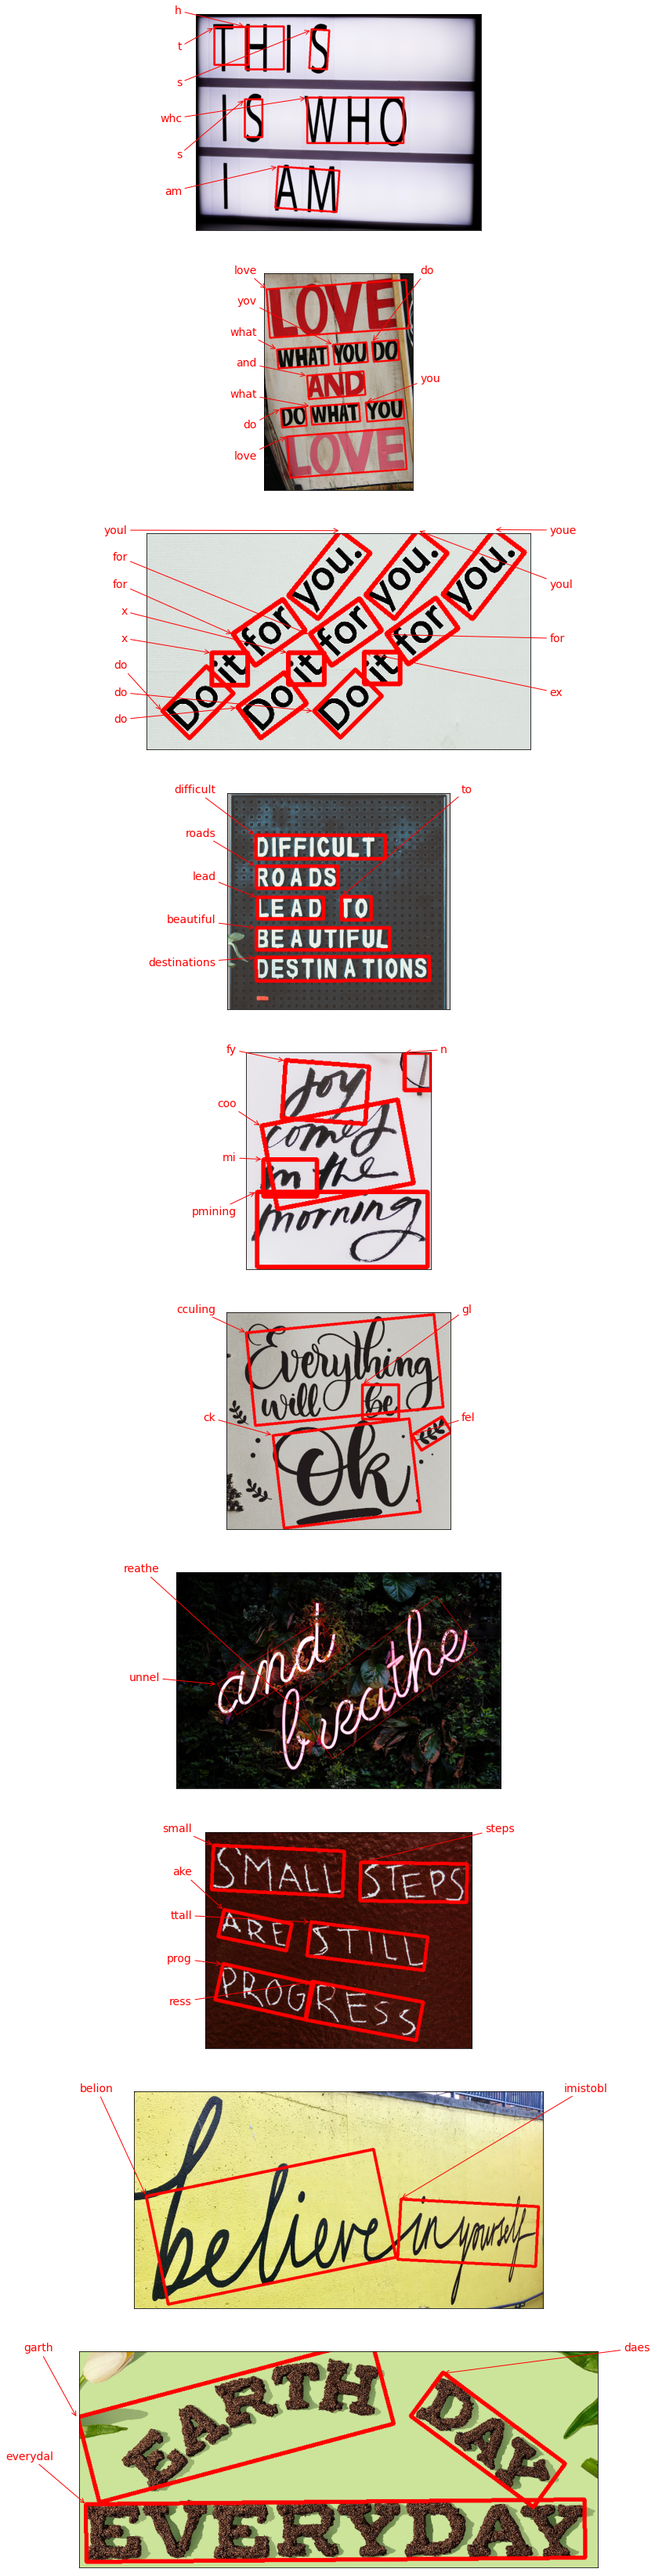

In [4]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 60))
for idx, ax in enumerate(axs):
    img = images[idx]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    keras_ocr.tools.drawAnnotations(image=img, predictions=prediction_groups[idx][0], ax=ax)

분석
1. I를 제외한 모든 단어를 찾아냈습니다. 나쁘지 않은 정확도 입니다.
2. 약간 기울어져 있지만 모든 단어를 찾아냈으며 정확도 또한 매우 높습니다.
3. 45도로 기울어져 있는 그림이지만 각각의 단어들을 알맞게 구분하고 있습니다.
It은 잘 못 읽어냈지만 나머지 단어들은 대부분 맞습니다.
4. 점자들과 같이 있는 보통 글씨체 그림입니다. 거의 완벽하게 읽어내고 있습니다.
5. 여기부터 필기체 그림입니다. 뜻은 대부분 맞지 않지만 단어 별로 묶어주고 있습니다.
6. 약간의 그림과 같이 있는 필기체입니다. 어느 정도 단어 별로 나눠주고 있지만 뜻은 다릅니다.
7. 기울어진 필기체 입니다. 단어 별로 나누지만 뜻은 완전히 다릅니다.
8. 손글씨입니다. 단어는 정확히 나누지만 뜻은 조금 다릅니다.
9. 쭉 이어진 필기체입니다. 단어로 한 번 나눕니다. 생긴 것처럼 뜻이 나옵니다.
10. 마지막으로 넣은 호 형태로 위치한 글입니다. 단어 별로 잘 나눕니다.

## Tesseract

### 함수 생성 및 적용

In [5]:
# crop_word_regions 함수를 정의합니다.
# parameter로는 image_path와 output_path를 받습니다.
# image_path의 입력 이미지로 부터 글자를 찾아서 output_path에 저장하는 것 같습니다.
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    # 입력한 ouput 폴더가 없다면 새롭게 생성합니다.
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    # oem, psm 을 각각 3으로 설정합니다. (둘다 기본값 입니다.)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    
    # image : image_path의 이미지
    # lang : 사용할 언어
    # config : 위의 oem3, psm3을 사용합니다.
    # output_type : ouput 종류
    # 1. Output.BYTES
    # 2. Output.DICT
    # 3. Output.STRING(default)
    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    # level 중 가장 높은 값을 top_level로 둔다. (해당 level : 1 ~ 5 이므로 5)     
    top_level = max(recognized_data['level'])
    # 인덱스 초기화
    index = 0
    # 이미지에서 잘라잰 부분을 저장할 리스트
    cropped_image_path_list = []
    # 전체 level의 갯수에 따라 반복
    for i in range(len(recognized_data['level'])):
        # recognized_data 딕셔너리의 key : level의 value
        level = recognized_data['level'][i]
        # level이 top_level(5) 일때
        if level == top_level:
            # 좌, 상단, 너비, 높이를 구합니다.
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            # output_path에 
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            # print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list , recognized_data

In [6]:
cropped_image_path_list_1, recognized_data_1 = crop_word_regions('images/1.png', 'data/output1')
cropped_image_path_list_2, recognized_data_2 = crop_word_regions('images/2.png', 'data/output2')
cropped_image_path_list_3, recognized_data_3 = crop_word_regions('images/3.png', 'data/output3')
cropped_image_path_list_4, recognized_data_4 = crop_word_regions('images/4.png', 'data/output4')
cropped_image_path_list_5, recognized_data_5 = crop_word_regions('images/5.png', 'data/output5')
cropped_image_path_list_6, recognized_data_6 = crop_word_regions('images/6.png', 'data/output6')
cropped_image_path_list_7, recognized_data_7 = crop_word_regions('images/7.jpg', 'data/output7')
cropped_image_path_list_8, recognized_data_8 = crop_word_regions('images/8.png', 'data/output8')
cropped_image_path_list_9, recognized_data_9 = crop_word_regions('images/9.png', 'data/output9')
cropped_image_path_list_10, recognized_data_10 = crop_word_regions('images/10.png', 'data/output10')

### 출력

In [7]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image)
        plt.show()
    print("완료")

#### 1

1번째 원본 이미지  
<img src = 'images/1.png' width = 30% height = 30%>

aio



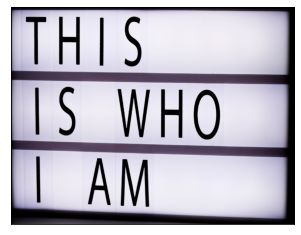

완료


In [8]:
recognize_images(cropped_image_path_list_1)

1번 이미지 분석
* 대부분 못잡아냅니다.

#### 2

2번째 원본 이미지  
<img src = 'images/2.png' width = 15% height = 15%>

|



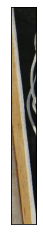

WHAT



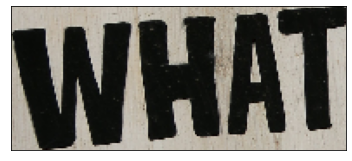

YOu



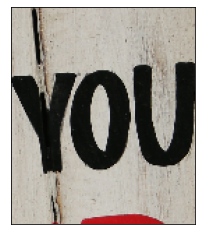

DO.



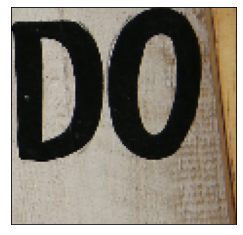

)



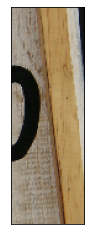

;



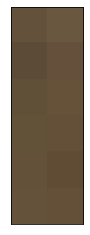

HO



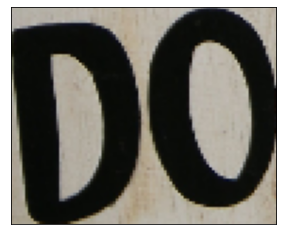

WHAT



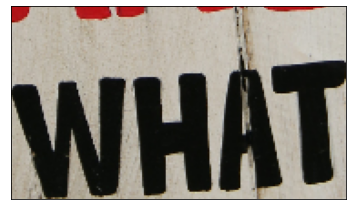

YOU!



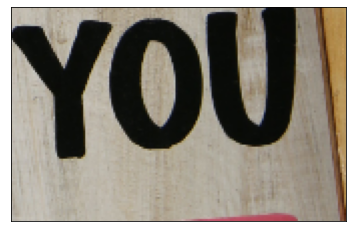

\\a



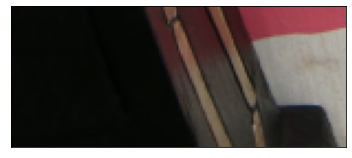

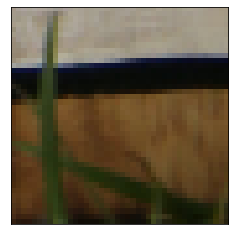

oa” An



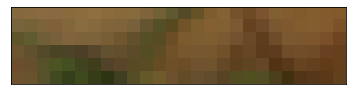

oF



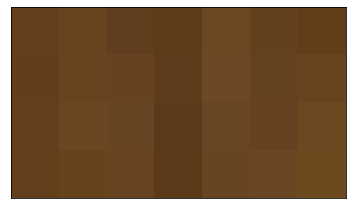

완료


In [9]:
recognize_images(cropped_image_path_list_2)

2번 이미지 분석
* 몇몇의 글씨는 확실히 잡아냅니다.
* 글자가 아닌 부분도 텍스트로 인식합니다.

#### 3

3번째 원본 이미지  
<img src = 'images/3.png' width = 20% height = 20%>

3”



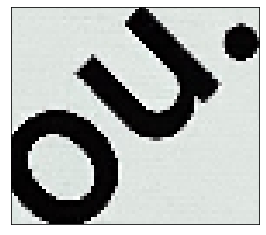

So” oO”



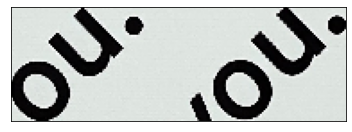

x



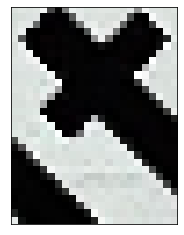

oe



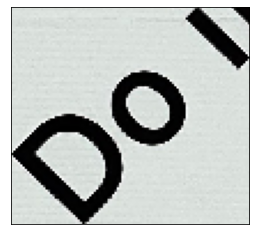

xe



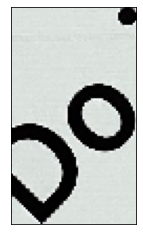

&



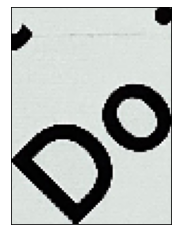

oO



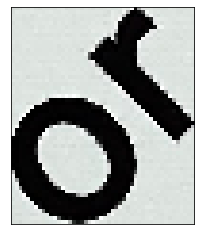

ww



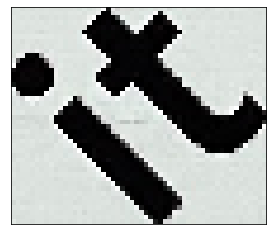

wv



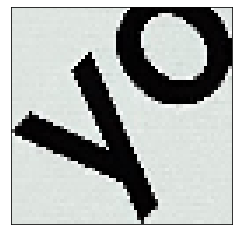

ww



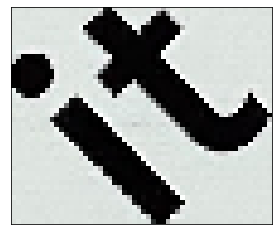

A



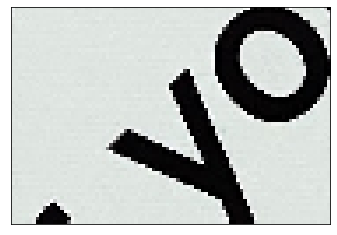

완료


In [10]:
recognize_images(cropped_image_path_list_3)

3번 이미지 분석
* 어느정도 단어대로 구분합니다.
* 뜻은 완전히 잡지 못합니다.

#### 4

4번째 원본 이미지  
<img src = 'images/4.png' width = 20% height = 20%>

DIFFICULT



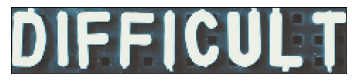

eee was



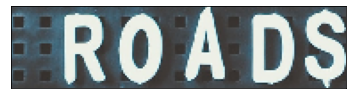

=e en ae



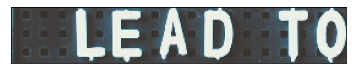

ee ee



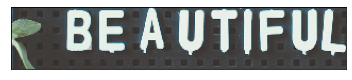

DESTINATIONS



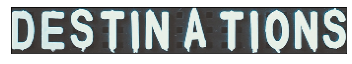

Coen



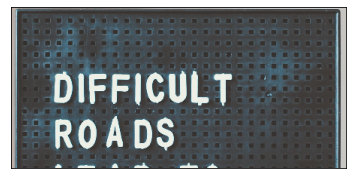

|



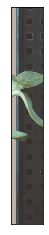

완료


In [11]:
recognize_images(cropped_image_path_list_4)

4번 이미지 분석
* 대부분의 글자를 잡아냅니다.
* 글자가 아닌 부분이나 전체 부분 또한 텍스트로 인식합니다.

#### 5

5번째 원본 이미지  
<img src = 'images/5.png' width = 20% height = 20%>

an



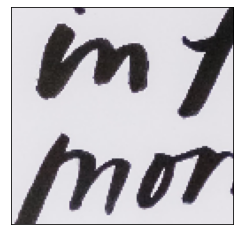

완료


In [12]:
recognize_images(cropped_image_path_list_5)

5번 이미지 분석
* 필기체를 넣는 순간 대부분의 글자 구분도 못하고 뜻 또한 맞지 않습니다.

#### 6

6번째 원본 이미지  
<img src = 'images/6.png' width = 20% height = 20%>

oh:



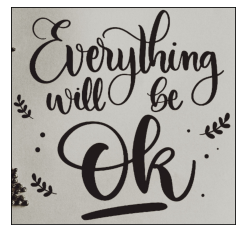

완료


In [13]:
recognize_images(cropped_image_path_list_6)

6번 이미지 분석
* 이번엔 전체 이미지를 텍스트로 인식하고 뜻 또한 맞지않습니다.

#### 7

7번째 원본 이미지  
<img src = 'images/7.jpg' width = 20% height = 20%>

mw



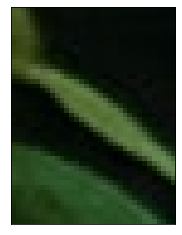

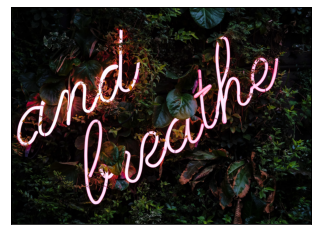

완료


In [14]:
recognize_images(cropped_image_path_list_7)

7번 이미지 분석
* 6번 거의 동일한 결과가 나옵니다.

#### 8

8번째 원본 이미지  
<img src = 'images/8.png' width = 20% height = 20%>

MALL



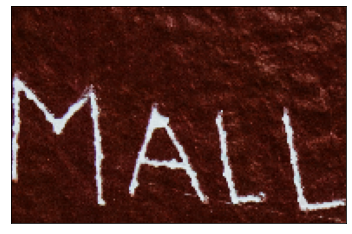

Kereta



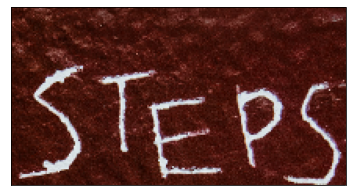

nara



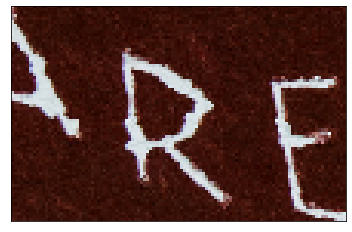

es



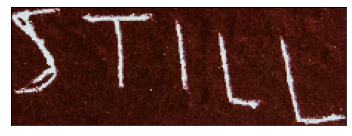

PROG



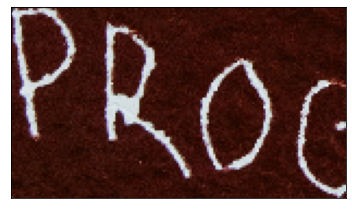

Ra



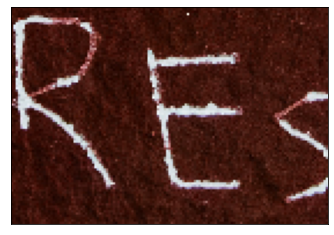

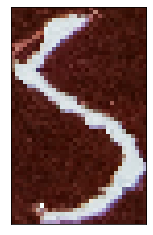

완료


In [15]:
recognize_images(cropped_image_path_list_8)

8번 이미지 분석
* 손글씨는 그나마 단어 구분을 합니다.
* 다만 뜻은 몇개를 제외하고는 다 맞지 않습니다.

#### 9

9번째 원본 이미지  
<img src = 'images/9.png' width = 20% height = 20%>

‘am



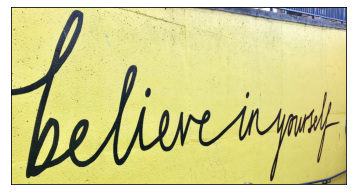

완료


In [16]:
recognize_images(cropped_image_path_list_9)

9번 이미지 분석
* 단어조차 잡지 못합니다.

#### 10

10번째 원본 이미지  
<img src = 'images/10.png' width = 20% height = 20%>

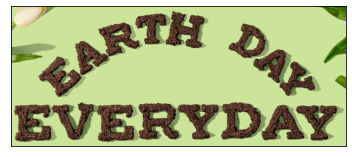

완료


In [17]:
recognize_images(cropped_image_path_list_10)

10번 이미지 분석
* 복잡한 형태는 아예 잡지 못하는 것 같습니다.

## 결과 분석 및 결론

### 나의 서비스

* 생각한 서비스 : 여러 상황(이상치 또는 각도)에서 기본 글씨와 더불어 필기체 또한 글자로 구분하고 뜻 또한 파악해내는 Task
* 목적 : 단순한 글 말고도 필기체가 사용되는 간판 또는 문서에도 적용할 수 있게 하기 위해

### 결과 분석

Keras-OCR
* 기울어져 있든, 점자들이나 다른 그림들이 같이 있든, 필기체든, 기본 글씨체든 이미지에서 대부분 단어에 알맞게 나눕니다.
* 단 필기체 그림으로 가면 뜻을 거의 찾지 못하지만 그나마 형태 그대로의 의미를 반환합니다.

Tesseract
* 이상치(다른 그림, 각도)가 심한 경우 단어 구분을 아예 못하고 그냥 이미지 전체를 반환하는 경우가 빈번했습니다.
* 위와 같은 상황은 필기체인 경우 특히 더 심하게 나타났습니다.
* 정확하게 놓여진 단어의 경우에만 캐치하여 정확한 뜻을 나타내는 경우가 있었지만 대부분 그러지 못했습니다.(샘플 이미지에 대부분 이상치가 많아서 나온 결과일 수 도 있습니다.)

### 결론

필기체의 의미를 제대로 도출하는 것을 떠나서 필기체 자체를 인식하고 거기서 단어를 구분하는 경우에 대해서 알아보면  
Keras-OCR은 일단 필기체에서 text를 제대로 찾고 단어를 대부분 제대로 구분하는 반면  
Tesseract는 이상치에 너무 약한 모습을 보이고 필기체에 관해선 Text 자체도 제대로 못 잡는 경우가 많았습니다.  
그리하여 본 서비스를 구현하기 위해서는 keras-ocr을 사용해 단어를 구분하고 이미지에서 필기체를 읽어내는 모델을 추가하여 사용하는 것이 더 바람직하다고 봅니다.

## 회고

* 이번 프로젝트에서 어려웠던 점
    - 원본 이미지 자체를 사용하니 제대로 단어를 인식하지 못해서 모델의 세부 구성을 변경하고 싶었으나 방법이 어려워서 포기하였습니다.
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  * 알게 된 점
    - keras-ocr 사용시 url 말고 local image를 사용하는 방법을 알았습니다.
  * 아직 모호한 점
    - tesseract 가 이상치에 너무 약한게 이해가 가지 않습니다.(level5이니 그나마 강한거라고 생각들긴 합니다. + level이 높다고 꼭 좋은 건 아닌 것 같습니다.)
* 루브릭 평가를 맞추기 위해 시도한 점
    - 생각한 서비스에 대한 목적과 용도, OCR과의 연관성 서술
    - 생각한 기준에 따라 샘플 이미지를 가져옴(기본 글씨체와 필기체 + 여러 상황(이상치 or 각도))
    - 각 이미지에 대한 설명 기입 및 원본 이미지 또한 출력
